In [1]:
import os, sys
import pickle
sys.path.append("../")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import gridspec
from matplotlib import ticker
import seaborn as sns
import numpy as np
from scipy.integrate import cumtrapz
from tqdm import *

from grf.grf import PerturbedProbability, FIRAS
from grf.pk_interp import PowerSpectrumGridInterpolator
from grf.units import *

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load plot settings

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [3]:
# Where to save plots
plots_dir = "../paper/draft-formalism/plots/"

## d$P$/d$z$ plots for various PDFs

In [4]:
# Load nonlinear matter spectrum with a baryon Jeans scale suppression
log_pspec = PowerSpectrumGridInterpolator("franken_lower")

In [5]:
# Load analytic PDF
log_analytic_pdf_interp = pickle.load(open('../data/analytic_pdf_grids/log_analytic_pdf_interp.npy', 'rb'))

In [6]:
prob = PerturbedProbability(log_pspec)
firas = FIRAS(log_pspec)  # Also load a FIRAS class to access the FIRAS frequencies, as benchmarks

../grf/grf.py:633: FutureWarning: read_table is deprecated, use read_csv instead.
  names=['freq', 'I', 'residual', 'uncert', 'poles'])


In [7]:
def as_si(x, ndp, dolla=0):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    if float(m) == 1.:
        s = r'10^{{{e:d}}}'.format(m=m, e=int(e))
    else:
        s = r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))
    if dolla:
        return '$' + s + '$'
    else:
        return s

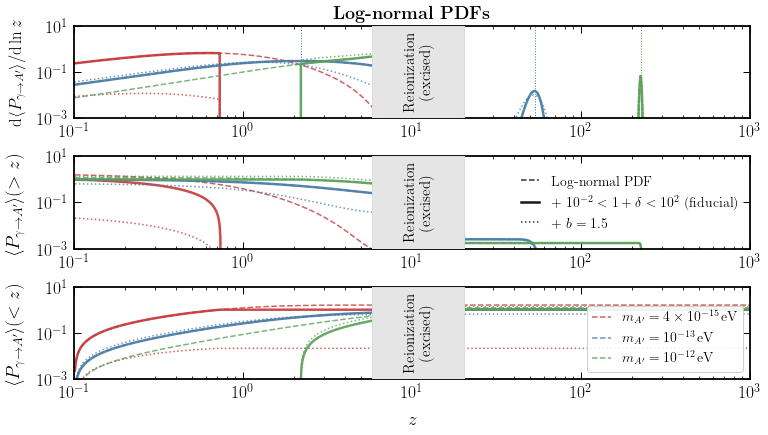

In [13]:
fig = plt.figure(figsize=(14 / 1.3, 8 / 1.3)) 
lw_reduced = 1.5
alpha_reduced = 0.8 

## Define gridspec
gs = gridspec.GridSpec(3, 1) 

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

z_ary = np.logspace(-1, 3, 1000)
z_ary_cum = np.concatenate([z_ary[z_ary < 6], z_ary[z_ary > 20]])

# Dark photon mass 
m_Ap_ary = [4e-15 * eV, 1e-13 * eV, 1e-12 * eV]  
one_plus_delta_bound = 1e2

for i_m_Ap, m_Ap in enumerate(m_Ap_ary):
    
    # Frequencies of interest (we are only going to plot results corresponding to the lower frequency)
    omega_ary = firas.omega_FIRAS

    # Get homogeneous crossings, to see where they are!
    z_homogeneous_crossings = prob.get_z_crossings(m_Ap, omega_ary[0])

    # Using log-normal PDF
    dPdz_bounded_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='lognormal', one_plus_delta_bound=one_plus_delta_bound)[0][0]
    dPdz_bounded_ary_cum = np.concatenate([dPdz_bounded_ary[z_ary < 6], dPdz_bounded_ary[z_ary > 20]])    
    dPdz_bounded_ary /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)
    
    ax0.plot(z_ary, z_ary * dPdz_bounded_ary, color=cols_default[i_m_Ap])

    # Using log-normal PDF
    dPdz_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='lognormal', one_plus_delta_bound=None)[0][0]
    dPdz_ary_cum = np.concatenate([dPdz_ary[z_ary < 6], dPdz_ary[z_ary > 20]])
    dPdz_ary /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)

    ax0.plot(z_ary, z_ary * dPdz_ary, color=cols_default[i_m_Ap], ls='--', lw=lw_reduced, alpha=alpha_reduced)

    # Using log-normal PDF
    dPdz_voids_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='lognormal', b=1.5, one_plus_delta_bound=one_plus_delta_bound)[0][0]
    dPdz_voids_ary_cum = np.concatenate([dPdz_voids_ary[z_ary < 6], dPdz_voids_ary[z_ary > 20]])
    dPdz_voids_ary /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)
    
    ax0.plot(z_ary, z_ary * dPdz_voids_ary, label="Log-normal", color=cols_default[i_m_Ap], ls='dotted', lw=lw_reduced, alpha=alpha_reduced)

    for z_cross in z_homogeneous_crossings:
        ax0.axvline(z_cross, ls='dotted', lw=1, color=cols_default[i_m_Ap])
    
    dPdz_voids_ary_cum /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)
    dPdz_ary_cum /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)
    dPdz_bounded_ary_cum /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)

    ax1.plot(z_ary_cum[1:], - cumtrapz(dPdz_ary_cum[::-1], z_ary_cum[::-1])[::-1], color=cols_default[i_m_Ap], ls='--', lw=lw_reduced, alpha=alpha_reduced)
    ax1.plot(z_ary_cum[1:], - cumtrapz(dPdz_bounded_ary_cum[::-1], z_ary_cum[::-1])[::-1], color=cols_default[i_m_Ap])
    ax1.plot(z_ary_cum[1:], - cumtrapz(dPdz_voids_ary_cum[::-1], z_ary_cum[::-1])[::-1], color=cols_default[i_m_Ap], ls='dotted', lw=lw_reduced, alpha=alpha_reduced)

    ax2.plot(z_ary_cum[1:], cumtrapz(dPdz_ary_cum, z_ary_cum), color=cols_default[i_m_Ap], label=r"$m_{A'} = " + as_si(m_Ap / eV, 0) + "\,\mathrm{eV}$", ls='--', lw=lw_reduced, alpha=alpha_reduced)
    ax2.plot(z_ary_cum[1:], cumtrapz(dPdz_bounded_ary_cum, z_ary_cum), color=cols_default[i_m_Ap])
    ax2.plot(z_ary_cum[1:], cumtrapz(dPdz_voids_ary_cum, z_ary_cum), color=cols_default[i_m_Ap], ls='dotted', lw=lw_reduced, alpha=alpha_reduced)
    
for ax in fig.axes:

    offset = -0.2
    a1 = ax.axvspan(6 + offset, 20 - offset, color='white', alpha=1)
    a1.set_zorder(20)
    a2 = ax.axvspan(6 + offset, 20 - offset, color='grey', alpha=0.2)
    a2.set_zorder(21)
    a3 = ax.text(10 ** ((np.log10(6) + np.log10(20)) / 2.), 1e-1, "Reionization \n(excised)", rotation=90, fontsize=15, multialignment="center", va="center", ha="center")
    a3.set_zorder(22)
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(min(z_ary), max(z_ary))
    ax.set_ylim(1e-3, 1e1)
        
ax0.set_ylabel(r"$\mathrm{d}\langle P_{\gamma\to A'}\rangle/\mathrm{d}\ln z$", fontsize=17)
ax1.set_ylabel(r"$\langle P_{\gamma\to A'}\rangle(> z)$")
ax2.set_ylabel(r"$\langle P_{\gamma\to A'}\rangle(< z)$")
ax2.set_xlabel("$z$")

ax0.set_title(r"\bf{Log-normal PDFs}")

ax1.plot([],[], c='k', ls='dashed', label="Log-normal PDF", lw=lw_reduced, alpha=alpha_reduced)
ax1.plot([],[], c='k', ls='solid', label="$+ \,\,10^{-2} < 1 + \delta < 10^2$ (fiducial)")
ax1.plot([],[], c='k', ls='dotted', label="$+ \,\,b=1.5$", lw=lw_reduced, alpha=alpha_reduced)
ax1.legend(fontsize=14, loc='center right', handlelength=1.3)

ax2.legend(fontsize=14, ncol=1, frameon=True, loc='lower right', framealpha=0.9, handlelength=1.3)

plt.tight_layout()
plt.savefig(plots_dir + "dP_dz_ln.pdf")

../grf/grf.py:461: RuntimeWarning: invalid value encountered in log10
  log_pdf = pdf(np.log10(input_ary))
../grf/grf.py:437: RuntimeWarning: invalid value encountered in log10
  t_ary = (np.log10(one_plus_delta_ary*Omega_m) -


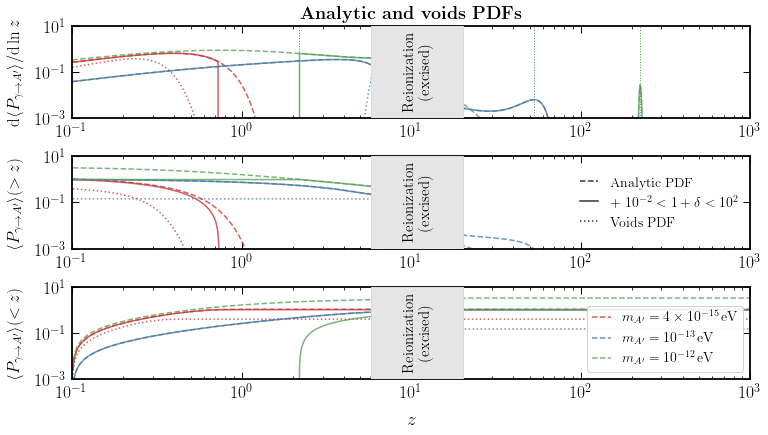

In [12]:
fig = plt.figure(figsize=(14 / 1.3, 8 / 1.3)) 

## Define gridspec
gs = gridspec.GridSpec(3, 1) 

ax3 = plt.subplot(gs[0])
ax4 = plt.subplot(gs[1])
ax5 = plt.subplot(gs[2])

z_ary = np.logspace(-1, 3, 1000)
z_ary_cum = np.concatenate([z_ary[z_ary < 6], z_ary[z_ary > 20]])

# Dark photon mass 
m_Ap_ary = [4e-15 * eV, 1e-13 * eV, 1e-12 * eV]  
one_plus_delta_bound = 1e2

for i_m_Ap, m_Ap in enumerate(m_Ap_ary):
    
    # Frequencies of interest (we are only going to plot results corresponding to the lower frequency)
    omega_ary = firas.omega_FIRAS

    # Get homogeneous crossings, to see where they are!
    z_homogeneous_crossings = prob.get_z_crossings(m_Ap, omega_ary[0])

    # Using log-normal PDF
    dPdz_bounded_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='lognormal', one_plus_delta_bound=one_plus_delta_bound)[0][0]
    dPdz_bounded_ary_cum = np.concatenate([dPdz_bounded_ary[z_ary < 6], dPdz_bounded_ary[z_ary > 20]])    
    dPdz_bounded_ary /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)
    
    ## Analytic

    dPdz_bounded_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf=log_analytic_pdf_interp, one_plus_delta_bound=one_plus_delta_bound)[0][0]
    dPdz_bounded_ary_cum = np.concatenate([dPdz_bounded_ary[z_ary < 6], dPdz_ary[z_ary > 20]])    
    dPdz_bounded_ary /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)

    ax3.plot(z_ary, z_ary * dPdz_bounded_ary, label="Log-normal", color=cols_default[i_m_Ap], lw=lw_reduced, alpha=alpha_reduced)

    # Using log-normal PDF
    dPdz_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf=log_analytic_pdf_interp, one_plus_delta_bound=None)[0][0]
    dPdz_ary_cum = np.concatenate([dPdz_ary[z_ary < 6], dPdz_ary[z_ary > 20]])
    dPdz_ary /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)
    
    ax3.plot(z_ary, z_ary * dPdz_ary, color=cols_default[i_m_Ap], ls='--', lw=lw_reduced, alpha=alpha_reduced)

    # Using log-normal PDF
    dPdz_voids_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='voids', b=1.5, one_plus_delta_bound=one_plus_delta_bound)[0][0]
    dPdz_voids_ary_cum = np.concatenate([dPdz_voids_ary[z_ary < 6], dPdz_voids_ary[z_ary > 20]])
    dPdz_voids_ary /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)
    
    ax3.plot(z_ary, z_ary * dPdz_voids_ary, label="Log-normal", color=cols_default[i_m_Ap], ls='dotted', lw=lw_reduced, alpha=alpha_reduced)

    for z_cross in z_homogeneous_crossings:
        ax3.axvline(z_cross, ls='dotted', lw=1, color=cols_default[i_m_Ap])

    dPdz_voids_ary_cum /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)
    dPdz_ary_cum /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)
    dPdz_bounded_ary_cum /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)

    ax4.plot(z_ary_cum[1:], - cumtrapz(dPdz_ary_cum[::-1], z_ary_cum[::-1])[::-1], color=cols_default[i_m_Ap], ls='--', lw=lw_reduced, alpha=alpha_reduced)
    ax4.plot(z_ary_cum[1:], - cumtrapz(dPdz_bounded_ary_cum[::-1], z_ary_cum[::-1])[::-1], color=cols_default[i_m_Ap], lw=lw_reduced, alpha=alpha_reduced)
    ax4.plot(z_ary_cum[1:], - cumtrapz(dPdz_voids_ary_cum[::-1], z_ary_cum[::-1])[::-1], color=cols_default[i_m_Ap], ls='dotted', lw=lw_reduced, alpha=alpha_reduced)

    ax5.plot(z_ary_cum[1:], cumtrapz(dPdz_ary_cum, z_ary_cum), color=cols_default[i_m_Ap], label=r"$m_{A'} = " + as_si(m_Ap / eV, 0) + "\,\mathrm{eV}$", ls='--', lw=lw_reduced, alpha=alpha_reduced)
    ax5.plot(z_ary_cum[1:], cumtrapz(dPdz_bounded_ary_cum, z_ary_cum), color=cols_default[i_m_Ap], lw=lw_reduced, alpha=alpha_reduced)
    ax5.plot(z_ary_cum[1:], cumtrapz(dPdz_voids_ary_cum, z_ary_cum), color=cols_default[i_m_Ap], ls='dotted', lw=lw_reduced, alpha=alpha_reduced)

for ax in fig.axes:

    offset = -0.2
    a1 = ax.axvspan(6 + offset, 20 - offset, color='white', alpha=1)
    a1.set_zorder(20)
    a2 = ax.axvspan(6 + offset, 20 - offset, color='grey', alpha=0.2)
    a2.set_zorder(21)
    a3 = ax.text(10 ** ((np.log10(6) + np.log10(20)) / 2.), 1e-1, "Reionization \n(excised)", rotation=90, fontsize=15, multialignment="center", va="center", ha="center")
    a3.set_zorder(22)
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(min(z_ary), max(z_ary))
    ax.set_ylim(1e-3, 1e1)
        
ax3.set_ylabel(r"$\mathrm{d}\langle P_{\gamma\to A'}\rangle/\mathrm{d}\ln z$", fontsize=17)
ax4.set_ylabel(r"$\langle P_{\gamma\to A'}\rangle(> z)$", fontsize=17)
ax5.set_ylabel(r"$\langle P_{\gamma\to A'}\rangle(< z)$", fontsize=17)
ax5.set_xlabel("$z$")

ax3.set_title(r"\bf{Analytic and voids PDFs}")

ax4.plot([],[], c='k', ls='dashed', label="Analytic PDF", lw=lw_reduced, alpha=alpha_reduced)
ax4.plot([],[], c='k', ls='solid', label="$+ \,\,10^{-2} < 1 + \delta < 10^2$", lw=lw_reduced, alpha=alpha_reduced)
ax4.plot([],[], c='k', ls='dotted', label="Voids PDF", lw=lw_reduced, alpha=alpha_reduced)
ax4.legend(fontsize=14, loc='center right', handlelength=1.3)

ax5.legend(fontsize=14, ncol=1, frameon=True, loc='lower right', framealpha=0.9, handlelength=1.3)

plt.tight_layout()
plt.savefig(plots_dir + "dP_dz_an.pdf")

## Probability as function of $k_\mathrm{max}$

In [174]:
# Dark photon mass 
m_Ap_ary = [4e-15 * eV, 1e-13 * eV, 1e-12 * eV]  
one_plus_delta_bound = 1e2

k_ary = np.logspace(-2, 4, 100)
z_ary = np.logspace(-1, 3, 1000)
z_ary_cum = np.concatenate([z_ary[z_ary < 6], z_ary[z_ary > 20]])

P_ary = np.zeros((len(m_Ap_ary), len(k_ary)))
P_2_ary = np.zeros((len(m_Ap_ary), len(k_ary)))

for i_m_Ap, m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):
    for i_k, k_max in enumerate(tqdm_notebook(k_ary)):
        dPdz_bounded_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=k_max, omega=omega_ary, pdf="lognormal", one_plus_delta_bound=one_plus_delta_bound)[0][0]
        dPdz_bounded_ary_cum = np.concatenate([dPdz_bounded_ary[z_ary < 6], dPdz_bounded_ary[z_ary > 20]])    
        dPdz_bounded_ary /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)

        P_ary[i_m_Ap, i_k] = np.trapz(dPdz_bounded_ary_cum, z_ary_cum)
        
        dPdz_bounded_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=k_max, omega=omega_ary, pdf="lognormal", one_plus_delta_bound=None)[0][0]
        dPdz_bounded_ary_cum = np.concatenate([dPdz_bounded_ary[z_ary < 6], dPdz_bounded_ary[z_ary > 20]])    
        dPdz_bounded_ary /= np.trapz(dPdz_bounded_ary_cum, z_ary_cum)

        P_2_ary[i_m_Ap, i_k] = np.trapz(dPdz_bounded_ary_cum, z_ary_cum)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


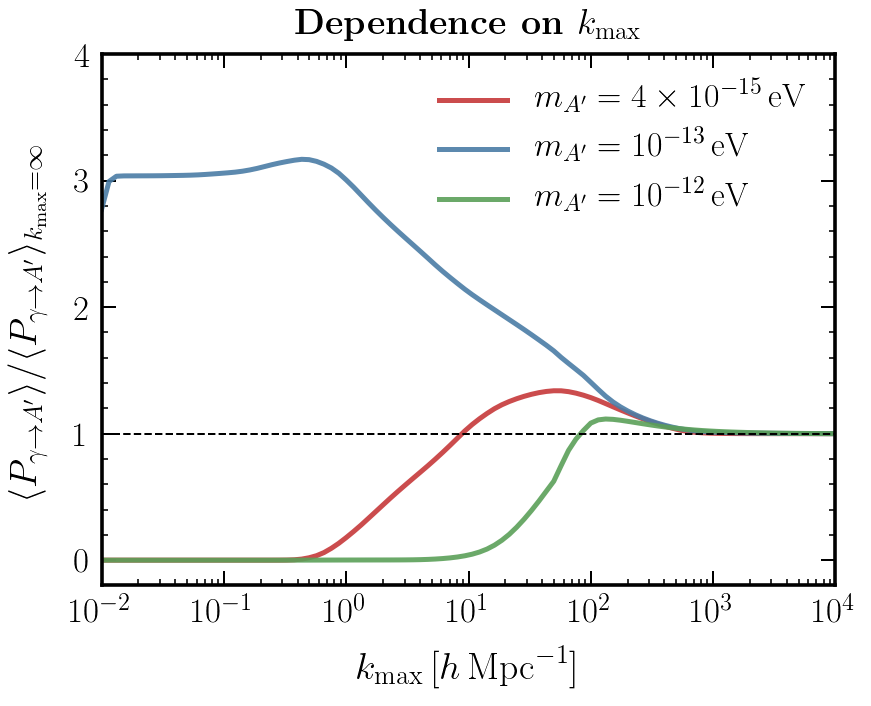

In [177]:
for i_m_Ap, m_Ap in enumerate((m_Ap_ary)):
    plt.plot(k_ary, P_ary[i_m_Ap] / P_ary[i_m_Ap][-1], label=r"$m_{A'} = " + as_si(m_Ap / eV, 0) + "\,\mathrm{eV}$")

plt.axhline(1, ls='--', lw=1, c='k')
plt.xscale("log")
plt.xlim(min(k_ary), max(k_ary))
plt.ylim(-0.2, 4)
plt.xlabel(r"$k_\mathrm{max}\,[h\,\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\langle P_{\gamma\to A'}\rangle / \langle P_{\gamma\to A'}\rangle_{k_\mathrm{max} = \infty}$")
plt.title(r"\textbf{Dependence on $k_\mathrm{max}$}")
plt.legend()

plt.tight_layout()
plt.savefig(plots_dir + "P_k_max.pdf")

## Total probability plot

In [14]:
one_plus_delta_bound = 1e2  # Fiducial bound
omega_ary = np.array([firas.omega_FIRAS[0]])  # Fiducial present-day frequency
m_Ap_ary = np.logspace(-16, -9, 100) * eV  # Masses to scan over

In [15]:
z_ary = np.logspace(-2, np.log10(200), 500)
z_ary_cum = np.concatenate([z_ary[z_ary < 6], z_ary[z_ary > 20]])

In [16]:
# Log-normal PDF

P_tot_ary = np.zeros_like(m_Ap_ary)

for i_m_Ap, m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):

    dPdz_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='lognormal', one_plus_delta_bound=None)[0][0]
    dPdz_ary_cum = np.concatenate([dPdz_ary[z_ary < 6], dPdz_ary[z_ary > 20]])
    P_tot_ary[i_m_Ap] = np.trapz(dPdz_ary_cum, z_ary_cum)
    
# Log-normal PDF with \delta bound

P_tot_bounded_ary = np.zeros_like(m_Ap_ary)

for i_m_Ap, m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):
    dPdz_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='lognormal', one_plus_delta_bound=one_plus_delta_bound)[0][0]
    dPdz_ary_cum = np.concatenate([dPdz_ary[z_ary < 6], dPdz_ary[z_ary > 20]])
    P_tot_bounded_ary[i_m_Ap] = np.trapz(dPdz_ary_cum, z_ary_cum)

# Log-normal PDF with b=1.5

P_tot_bounded_b1p5_ary = np.zeros_like(m_Ap_ary)

for i_m_Ap, m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):
    dPdz_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='lognormal', b=1.5, one_plus_delta_bound=one_plus_delta_bound)[0][0]
    dPdz_ary_cum = np.concatenate([dPdz_ary[z_ary < 6], dPdz_ary[z_ary > 20]])
    P_tot_bounded_b1p5_ary[i_m_Ap] = np.trapz(dPdz_ary_cum, z_ary_cum)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [17]:
# Analytic PDF, bounded

P_tot_an_ary = np.zeros_like(m_Ap_ary)

for i_m_Ap, m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):
    dPdz_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf=log_analytic_pdf_interp, one_plus_delta_bound=one_plus_delta_bound)[0][0]
    dPdz_ary_cum = np.concatenate([dPdz_ary[z_ary < 6], dPdz_ary[z_ary > 20]])
    P_tot_an_ary[i_m_Ap] = np.trapz(dPdz_ary_cum, z_ary_cum)
    
# Voids PDF, bounded

P_tot_voids_ary = np.zeros_like(m_Ap_ary)

for i_m_Ap, m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):
    dPdz_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf="voids", one_plus_delta_bound=one_plus_delta_bound)[0][0]
    dPdz_ary_cum = np.concatenate([dPdz_ary[z_ary < 6], dPdz_ary[z_ary > 20]])
    P_tot_voids_ary[i_m_Ap] = np.trapz(dPdz_ary_cum[z_ary_cum < 6], z_ary_cum[z_ary_cum < 6])


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [18]:
# Log-normal PDF

P_tot_gauss_ary = np.zeros_like(m_Ap_ary)

for i_m_Ap, m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):

    dPdz_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='gaussian', one_plus_delta_bound=None)[0][0]
    dPdz_ary_cum = np.concatenate([dPdz_ary[z_ary < 6], dPdz_ary[z_ary > 20]])
    P_tot_gauss_ary[i_m_Ap] = np.trapz(dPdz_ary_cum, z_ary_cum)


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [19]:
# Homogeneous

P_tot_homo_ary = np.zeros_like(m_Ap_ary)

for i_m_Ap, m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):

    P_tot = prob.P_tot(omega_ary, 1, m_Ap, sum_probs=1)[2]
#     dPdz_ary_cum = np.concatenate([dPdz_ary[z_ary < 6], dPdz_ary[z_ary > 20]])
    P_tot_homo_ary[i_m_Ap] = P_tot


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


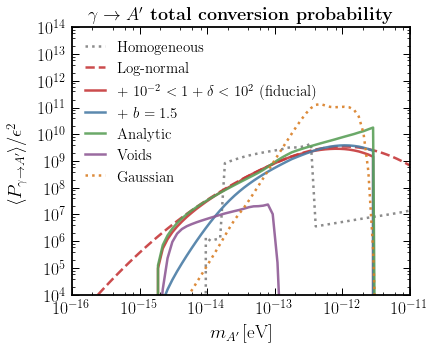

In [24]:
plt.plot(m_Ap_ary / eV, P_tot_homo_ary, color='grey', label="Homogeneous", ls='dotted')
plt.plot(m_Ap_ary / eV, P_tot_ary, color=cols_default[0], ls='--', label="Log-normal")
plt.plot(m_Ap_ary / eV, P_tot_bounded_ary, color=cols_default[0], label="$+ \,\,10^{-2} < 1 + \delta < 10^2$ (fiducial)")
plt.plot(m_Ap_ary / eV, P_tot_bounded_b1p5_ary, color=cols_default[1],label="$+ \,\,b=1.5$")
plt.plot(m_Ap_ary / eV, P_tot_an_ary, color=cols_default[2], label="Analytic")
plt.plot(m_Ap_ary / eV, P_tot_voids_ary, color=cols_default[3], label="Voids")
plt.plot(m_Ap_ary / eV, P_tot_gauss_ary, color=cols_default[4], label="Gaussian", ls='dotted')

# plt.text(0.8e-11, 1.1e-2, r"$\epsilon = 10^{-6}$", fontsize=15)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("$m_{A'}$\,[eV]")
plt.ylabel(r"$\langle P_{\gamma\to A'}\rangle/\epsilon^2$")

plt.xlim(1e-16, 1e-11)
plt.ylim(1e-8 * 1e6 ** 2, 1e2 * 1e6 ** 2)

ax = plt.gca()

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.legend(loc='upper left', fontsize=15, ncol=1, handlelength=1.3)

plt.title(r"\bf{$\gamma\to A'$ total conversion probability}")

plt.tight_layout()
plt.savefig(plots_dir + "P_tot_m_Ap.pdf")

In [21]:
one_plus_delta_ary = [10, 1e2, 1e3, 1e4]

P_tot_opd_ary = np.zeros((len(one_plus_delta_ary), len(m_Ap_ary)))

for i_opd, one_plus_delta in enumerate(one_plus_delta_ary):
    
    # Log-normal PDF

    for i_m_Ap, m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):

        dPdz_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='lognormal', one_plus_delta_bound=one_plus_delta)[0][0]
        dPdz_ary_cum = np.concatenate([dPdz_ary[z_ary < 6], dPdz_ary[z_ary > 20]])
        P_tot_opd_ary[i_opd, i_m_Ap] = np.trapz(dPdz_ary_cum, z_ary_cum)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [22]:
one_plus_delta_ary = [10, 1e2, 1e3, 1e4]

P_tot_opd_an_ary = np.zeros((len(one_plus_delta_ary), len(m_Ap_ary)))

for i_opd, one_plus_delta in enumerate(one_plus_delta_ary):
    
    # Log-normal PDF

    for i_m_Ap, m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):

        dPdz_ary = prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf=log_analytic_pdf_interp, one_plus_delta_bound=one_plus_delta)[0][0]
        dPdz_ary_cum = np.concatenate([dPdz_ary[z_ary < 6], dPdz_ary[z_ary > 20]])
        P_tot_opd_an_ary[i_opd, i_m_Ap] = np.trapz(dPdz_ary_cum, z_ary_cum)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [26]:
colors_seq = sns.color_palette('Blues', n_colors=4) # sns.cubehelix_palette(4, start=1, rot=0)
colors_alt_seq = sns.color_palette('Reds', n_colors=4)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1a18dadf98> has a label of '_line4' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1a2b455dd8> has a label of '_line5' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1a2b455f60> has a label of '_line6' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1a2b455940> has a label of '_line7' which cannot be automatically adde

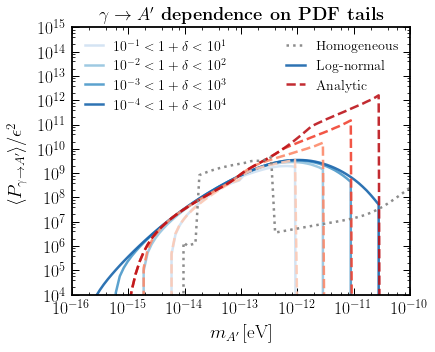

In [30]:
fig, ax=plt.subplots()

for i_opd, one_plus_delta_bound in enumerate(one_plus_delta_ary):
    plt.plot(m_Ap_ary / eV, P_tot_opd_ary[i_opd], label="$" + as_si(1 / one_plus_delta_bound, 1) + " < 1 + \delta < " + as_si(one_plus_delta_bound, 1) + "$", color=colors_seq[i_opd])

for i_opd, one_plus_delta_bound in enumerate(one_plus_delta_ary):
    plt.plot(m_Ap_ary / eV, P_tot_opd_an_ary[i_opd], ls='--', color=colors_alt_seq[i_opd])

plt.plot(m_Ap_ary / eV, P_tot_homo_ary, color='grey', label="Homogeneous", ls='dotted')

# Plot attributes

plt.plot([],[], label="Log-normal", color=colors_seq[-1])
plt.plot([],[], ls='--', label="Analytic", color=colors_alt_seq[-1])

plt.xscale("log")
plt.yscale("log")

plt.xlabel("$m_{A'}$\,[eV]")
plt.ylabel(r"$\langle P_{\gamma\to A'}\rangle/\epsilon^2$")

plt.xlim(1e-16, 1e-10)
plt.ylim(1e-8 * 1e6 ** 2, 1e3 * 1e6 ** 2)

ax = plt.gca()

lines = ax.get_lines()

## Create a legend for the first line.
first_legend = plt.legend(handles=lines[:-3], loc='upper left', fontsize=14, handlelength=1.3)

## Add the legend manually to the current Axes.
plt.gca().add_artist(first_legend)

## Create another legend for the second line.
plt.legend(handles=lines[-3:], loc='upper right', fontsize=14, handlelength=1.3)

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

# plt.legend(loc='upper left', fontsize=15, ncol=1)

plt.title(r"\bf{$\gamma \to A'$ dependence on PDF tails}")

plt.tight_layout()
plt.savefig(plots_dir + "P_tot_m_Ap_tails.pdf")